# Transfer Learning Part 2 : Fine Tuning

In [1]:
import tensorflow as tf
tf.__version__

'2.9.0'

In [2]:
# import helper functions
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data, walk_through_dir

--2023-05-22 18:27:23--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
Resolving github.com (github.com)... 20.207.73.82
Connecting to github.com (github.com)|20.207.73.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘helper_functions.py.1’

helper_functions.py     [  <=>               ] 263.37K   877KB/s    in 0.3s    

2023-05-22 18:27:24 (877 KB/s) - ‘helper_functions.py.1’ saved [269689]



See how to use the pretrained models within tf.keras.applications

In [3]:
# Get 10% of training data
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [4]:
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"


## OLD WAY
# Create Image data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## NEW WAY
# Use image_dataset_from_directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=(224,224),
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 shuffle=True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224,224),
                                                                label_mode="categorical",
                                                                batch_size=32,
                                                                shuffle=True)


Found 750 files belonging to 10 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-05-22 18:27:25.370942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-22 18:27:25.371450: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2500 files belonging to 10 classes.


In [5]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

None -> batch size(doesnt show the number usually)

(224,224,3) -> height,width,colour channel

(None,10) -> None = batch size |  10 -> number of classes in label tensor

In [6]:
# Check class names of dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
# See an example of a batch of data
for images,labels in train_data.take(1):
    print(images,labels)

2023-05-22 18:27:26.037652: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


tf.Tensor(
[[[[6.35714293e+00 1.35714281e+00 0.00000000e+00]
   [5.00000000e+00 1.00000000e+00 0.00000000e+00]
   [5.14285660e+00 1.78571415e+00 0.00000000e+00]
   ...
   [5.79596806e+00 1.42345536e+00 0.00000000e+00]
   [1.05714674e+01 6.88783884e-01 0.00000000e+00]
   [1.63571777e+01 2.00003481e+00 0.00000000e+00]]

  [[6.35714293e+00 1.35714281e+00 0.00000000e+00]
   [5.00000000e+00 1.00000000e+00 0.00000000e+00]
   [5.14285660e+00 1.78571415e+00 0.00000000e+00]
   ...
   [8.67353153e+00 3.41816425e-01 0.00000000e+00]
   [1.57806635e+01 2.85727262e-01 5.10297250e-03]
   [2.18316650e+01 2.47452211e+00 9.18317065e-02]]

  [[6.35714293e+00 1.35714281e+00 0.00000000e+00]
   [5.00000000e+00 1.00000000e+00 0.00000000e+00]
   [5.14285660e+00 1.78571415e+00 0.00000000e+00]
   ...
   [1.85663986e+01 2.78571415e+00 6.17363930e-01]
   [2.68724766e+01 3.85715580e+00 1.53060448e+00]
   [3.22092094e+01 4.78571415e+00 1.56628418e+00]]

  ...

  [[1.78570557e+00 3.21429443e+00 0.00000000e+00]
   [1

In [8]:
# Try building a model using tf.keras.applications
# efficient_net_model = tf.keras.models.Sequential([
#     tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=(480,480,3)),
#     tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)
# ])
# efficient_net_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#                             optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
#                             metrics=['accuracy'])
# efficientnet_history = efficient_net_model.fit(train_data,
#                                                epochs=5,
#                                                steps_per_epoch=len(train_data),
#                                                validation_data=test_data,
#                                                validation_steps=len(test_data))

### Using tf Functional model (different from Sequential model)

* Building a transfer learning model using keras Functional API
* Provides more flexibility compared to Seqquential model


In [9]:
# 1. Create a base model with tf.keras.applciations
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # include_top -> last layer (will be different for different datasets)

# 2. Freeze the base model, underlying pre-trained weights arent updated during training
base_model.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),
                               name="input_layer")

# 4. (Optional) -> if using resnet -> need to normalize inputs -> not needed for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to base_model
x = base_model(inputs)

print("shape after passing inputs through base_model: "+str(x.shape))

# 6. Average pool the outputs of the base_model (aggregate all most of information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="average_global_pooling_layer")(x)

print("Shape after GlobalAveragePooling2D: "+str(x.shape))

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax,name="output_layers")(x)

# 8. Combine input with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data),
                        callbacks=[create_tensorboard_callback("transferLearning",
                                                               "10_percent_feature_extraction")])

shape after passing inputs through base_model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transferLearning/10_percent_feature_extraction/20230522-182730
Epoch 1/5


2023-05-22 18:27:34.141057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 1.9243 - accuracy: 0.3787

2023-05-22 18:27:58.018118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 40s 1s/step - loss: 1.9243 - accuracy: 0.3787 - val_loss: 1.3329 - val_accuracy: 0.7297
Epoch 2/5
24/24 [==============================] - 21s 859ms/step - loss: 1.1356 - accuracy: 0.7680 - val_loss: 0.8735 - val_accuracy: 0.8344
Epoch 3/5
24/24 [==============================] - 17s 680ms/step - loss: 0.8008 - accuracy: 0.8293 - val_loss: 0.7043 - val_accuracy: 0.8594
Epoch 4/5
23/24 [===========================>..] - ETA: 0s - loss: 0.6508 - accuracy: 0.8533

In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 17s 218ms/step - loss: 0.5540 - accuracy: 0.8700


[0.5539881587028503, 0.8700000047683716]

In [ ]:
base_model.layers

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
# Get summary of the model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# Summary of full model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 average_global_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layers (Dense)       (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


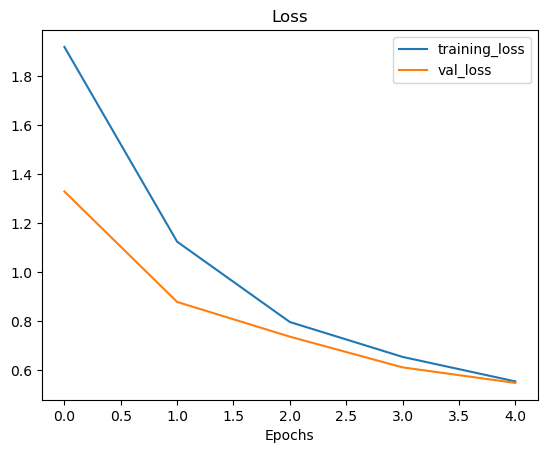

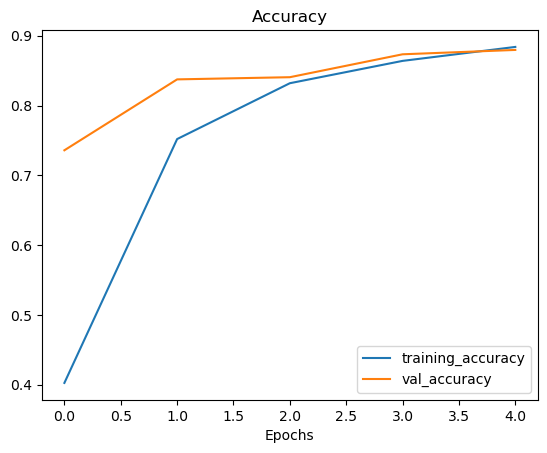

In [ ]:
plot_loss_curves(history_0)

### Practice Functional ApI method of building the model
1. using efficientnet
2. using resnet

In [ ]:
# using efficeintnet:
base_model_efficinetnet = tf.keras.applications.EfficientNetB0(include_top=False)

base_model_efficinetnet.trainable=False

inputs = tf.keras.layers.Input(shape=(224,224,3),
                               name="input_layer")

x = base_model_efficinetnet(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="GAP")(x)

outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax,name="output_layer")(x)

model_efficinetnet = tf.keras.Model(inputs,outputs)

model_efficinetnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_efficientnet = model_efficinetnet.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data))

Epoch 1/5


2023-05-02 07:24:11.887572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 1.9328 - accuracy: 0.3947

2023-05-02 07:24:19.758747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 16s 526ms/step - loss: 1.9328 - accuracy: 0.3947 - val_loss: 1.3263 - val_accuracy: 0.7500
Epoch 2/5
24/24 [==============================] - 10s 405ms/step - loss: 1.1276 - accuracy: 0.7533 - val_loss: 0.8848 - val_accuracy: 0.8391
Epoch 3/5
24/24 [==============================] - 10s 403ms/step - loss: 0.8051 - accuracy: 0.8307 - val_loss: 0.6997 - val_accuracy: 0.8453
Epoch 4/5
24/24 [==============================] - 10s 406ms/step - loss: 0.6415 - accuracy: 0.8640 - val_loss: 0.6026 - val_accuracy: 0.8766
Epoch 5/5
24/24 [==============================] - 10s 408ms/step - loss: 0.5548 - accuracy: 0.8827 - val_loss: 0.5344 - val_accuracy: 0.8750


In [ ]:
model_efficinetnet.evaluate(test_data)

79/79 [==============================] - 18s 229ms/step - loss: 0.5575 - accuracy: 0.8668


[0.557528555393219, 0.8668000102043152]

In [ ]:
# ResnetV2
base_model_resnet = tf.keras.applications.ResNet50(include_top=False)

base_model_resnet.trainable=False

inputs = tf.keras.layers.Input(shape=(224,224,3),
                               name="input_layer")

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model_resnet(x)

x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)

outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)

model_resnet = tf.keras.Model(inputs,outputs)

model_resnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_resnet = model_resnet.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=0.25*len(test_data))

Epoch 1/5


2023-05-02 07:25:25.685586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 2.3743 - accuracy: 0.0853

2023-05-02 07:25:36.310947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 20s 742ms/step - loss: 2.3743 - accuracy: 0.0853 - val_loss: 2.3286 - val_accuracy: 0.0859
Epoch 2/5
24/24 [==============================] - 15s 647ms/step - loss: 2.3373 - accuracy: 0.0840 - val_loss: 2.3143 - val_accuracy: 0.1125
Epoch 3/5
24/24 [==============================] - 16s 664ms/step - loss: 2.3160 - accuracy: 0.1120 - val_loss: 2.3086 - val_accuracy: 0.1078
Epoch 4/5
24/24 [==============================] - 16s 653ms/step - loss: 2.3162 - accuracy: 0.0933 - val_loss: 2.3059 - val_accuracy: 0.1016
Epoch 5/5
24/24 [==============================] - 15s 643ms/step - loss: 2.3221 - accuracy: 0.1093 - val_loss: 2.3058 - val_accuracy: 0.1250


In [ ]:
## EfficientNet -> practice
base_model_efficinetnet = tf.keras.applications.EfficientNetB7(include_top=False)
base_model_efficinetnet.trainable=False
inputs = tf.keras.layers.Input(shape=(224,224,3))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(x)
outputs = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)
model_efficinetnet = tf.keras.Model(inputs,outputs)
model_efficinetnet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                           metrics=["accuracy"])
history_efficientnet = model_efficinetnet.fit(train_data,
                                              epochs=8,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=(0.25*len(test_data)))

Epoch 1/8


2023-05-02 07:26:54.441153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 1.7671 - accuracy: 0.4613

2023-05-02 07:27:05.266788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 21s 677ms/step - loss: 1.7671 - accuracy: 0.4613 - val_loss: 1.0892 - val_accuracy: 0.8109
Epoch 2/8
24/24 [==============================] - 10s 424ms/step - loss: 0.9030 - accuracy: 0.7973 - val_loss: 0.7002 - val_accuracy: 0.8531
Epoch 3/8
24/24 [==============================] - 10s 428ms/step - loss: 0.6457 - accuracy: 0.8467 - val_loss: 0.5766 - val_accuracy: 0.8687
Epoch 4/8
24/24 [==============================] - 12s 474ms/step - loss: 0.5108 - accuracy: 0.8973 - val_loss: 0.5357 - val_accuracy: 0.8609
Epoch 5/8
24/24 [==============================] - 10s 426ms/step - loss: 0.4303 - accuracy: 0.9187 - val_loss: 0.4672 - val_accuracy: 0.8828
Epoch 6/8
24/24 [==============================] - 10s 415ms/step - loss: 0.3787 - accuracy: 0.9280 - val_loss: 0.4552 - val_accuracy: 0.8766
Epoch 7/8
24/24 [==============================] - 10s 402ms/step - loss: 0.3500 - accuracy: 0.9320 - val_loss: 0.4301 - val_accuracy: 0.8797
Epoch 8/8
24/24 

In [ ]:
model_efficinetnet.evaluate(test_data)

79/79 [==============================] - 19s 237ms/step - loss: 0.4310 - accuracy: 0.8788


[0.4310116171836853, 0.8787999749183655]

In [ ]:
### Last practice with resnet and efficient -> combined
base_model_eff = tf.keras.applications.EfficientNetB7(include_top=False)
base_model_res = tf.keras.applications.ResNet50(include_top=False)
base_model_eff_base = tf.keras.applications.EfficientNetB0(include_top=False)

base_model_eff.trainable=False
base_model_res.trainable=False
base_model_eff_base.trainable=False

inputs = tf.keras.Input(shape=(224,224,3),
                         name="input_layer")

norm = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model_eff(inputs)
y = base_model_res(norm)
z = base_model_eff_base(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(x)
y = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(y)
z = tf.keras.layers.GlobalAveragePooling2D(name="pooling")(z)

outputs1 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(x)
outputs2 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(y)
outputs3 = tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)(z)

model_eff = tf.keras.Model(inputs,outputs1)
model_res = tf.keras.Model(inputs,outputs2)
model_eff_base = tf.keras.Model(inputs,outputs3)

model_eff.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                  metrics=['accuracy'])
model_res.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                  metrics=['accuracy'])
model_eff_base.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0014),
                  metrics=['accuracy'])

history_eff = model_eff.fit(train_data,
                            epochs=8,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data)*0.25)
history_res = model_res.fit(train_data,
                            epochs=8,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data)*0.25)
history_eff_base = model_eff_base.fit(train_data,
                            epochs=8,
                            steps_per_epoch=len(train_data),
                            validation_data=test_data,
                            validation_steps=len(test_data)*0.25)

model_eff.evaluate(test_data)
model_res.evaluate(test_data)
model_eff_base.evaluate(test_data)

Epoch 1/8


2023-05-02 07:43:28.905243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 1.5106 - accuracy: 0.5747

2023-05-02 07:44:48.546166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 141s 5s/step - loss: 1.5106 - accuracy: 0.5747 - val_loss: 0.7678 - val_accuracy: 0.8484
Epoch 2/8
24/24 [==============================] - 68s 3s/step - loss: 0.7636 - accuracy: 0.8067 - val_loss: 0.5322 - val_accuracy: 0.8703
Epoch 3/8
24/24 [==============================] - 62s 3s/step - loss: 0.5964 - accuracy: 0.8560 - val_loss: 0.5053 - val_accuracy: 0.8562
Epoch 4/8
24/24 [==============================] - 64s 3s/step - loss: 0.5274 - accuracy: 0.8520 - val_loss: 0.4688 - val_accuracy: 0.8703
Epoch 5/8
24/24 [==============================] - 63s 3s/step - loss: 0.4409 - accuracy: 0.8987 - val_loss: 0.4429 - val_accuracy: 0.8703
Epoch 6/8
24/24 [==============================] - 68s 3s/step - loss: 0.3868 - accuracy: 0.9053 - val_loss: 0.4248 - val_accuracy: 0.8781
Epoch 7/8
24/24 [==============================] - 71s 3s/step - loss: 0.3691 - accuracy: 0.9213 - val_loss: 0.4088 - val_accuracy: 0.8797
Epoch 8/8
24/24 [===================

2023-05-02 07:53:29.870538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 2.4070 - accuracy: 0.0747

2023-05-02 07:53:52.962382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 42s 1s/step - loss: 2.4070 - accuracy: 0.0747 - val_loss: 2.3413 - val_accuracy: 0.1016
Epoch 2/8
24/24 [==============================] - 22s 941ms/step - loss: 2.3475 - accuracy: 0.0800 - val_loss: 2.3614 - val_accuracy: 0.1172
Epoch 3/8
24/24 [==============================] - 26s 1s/step - loss: 2.3393 - accuracy: 0.0960 - val_loss: 2.2991 - val_accuracy: 0.1172
Epoch 4/8
24/24 [==============================] - 24s 995ms/step - loss: 2.3268 - accuracy: 0.1120 - val_loss: 2.3346 - val_accuracy: 0.1125
Epoch 5/8
24/24 [==============================] - 21s 900ms/step - loss: 2.3243 - accuracy: 0.1227 - val_loss: 2.3117 - val_accuracy: 0.1016
Epoch 6/8
24/24 [==============================] - 20s 864ms/step - loss: 2.2905 - accuracy: 0.1280 - val_loss: 2.2819 - val_accuracy: 0.1203
Epoch 7/8
24/24 [==============================] - 23s 952ms/step - loss: 2.2896 - accuracy: 0.1413 - val_loss: 2.2797 - val_accuracy: 0.1172
Epoch 8/8
24/24 [=====

2023-05-02 07:56:59.752869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 1.7653 - accuracy: 0.4627

2023-05-02 07:57:30.348631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 58s 1s/step - loss: 1.7653 - accuracy: 0.4627 - val_loss: 1.0638 - val_accuracy: 0.7937
Epoch 2/8
24/24 [==============================] - 14s 570ms/step - loss: 0.9058 - accuracy: 0.7880 - val_loss: 0.7069 - val_accuracy: 0.8422
Epoch 3/8
24/24 [==============================] - 14s 574ms/step - loss: 0.6313 - accuracy: 0.8467 - val_loss: 0.5940 - val_accuracy: 0.8547
Epoch 4/8
24/24 [==============================] - 14s 569ms/step - loss: 0.5181 - accuracy: 0.8827 - val_loss: 0.5038 - val_accuracy: 0.8734
Epoch 5/8
24/24 [==============================] - 14s 577ms/step - loss: 0.4406 - accuracy: 0.9040 - val_loss: 0.4883 - val_accuracy: 0.8687
Epoch 6/8
24/24 [==============================] - 14s 581ms/step - loss: 0.3894 - accuracy: 0.9240 - val_loss: 0.4582 - val_accuracy: 0.8766
Epoch 7/8
24/24 [==============================] - 13s 550ms/step - loss: 0.3394 - accuracy: 0.9307 - val_loss: 0.4269 - val_accuracy: 0.8828
Epoch 8/8
79/79 [==

([0.43084385991096497, 0.8695999979972839],
 [2.2823195457458496, 0.12999999523162842],
 [0.4247400462627411, 0.8795999884605408])